ガラス基盤上に成膜したもの物性を使った学習

In [1]:
#------------------------
# Google Colab上でのみ実行
#------------------------
import time
%env TOKEN=*************************************
! git clone https://$$TOKEN@github.com/konnitiha3/MOD2NN.git

import sys
sys.path.append('/content/MOD2NN')

from google.colab import drive
drive.mount('/content/drive')

env: TOKEN=*************************************
Cloning into 'MOD2NN'...
remote: Enumerating objects: 980, done.
remote: Counting objects: 100% (151/151), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 980 (delta 60), reused 118 (delta 45), pack-reused 829
Receiving objects: 100% (980/980), 35.91 MiB | 7.30 MiB/s, done.
Resolving deltas: 100% (539/539), done.
Mounted at /content/drive


In [ ]:
import time
import os
import json
import sys
import re
import glob
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from Faraday.two_dim.module.lib.layers import *
from Faraday.two_dim.module.lib import regularizer

tf.random.set_seed(1)

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)

plt.rcParams['font.size'] = 18

In [ ]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-5000:]
y_val = y_train[-5000:]
x_train = x_train[:-5000]
y_train = y_train[:-5000]

In [ ]:
#@title デフォルトのタイトル テキスト
wavelength = 532.0e-9 #@param {type:"number"}
d = 1.0e-6 #@param {type:"number"}
n = 1.5 #@param {type:"number"}

In [ ]:
def create_model(**kwargs):
    tf.random.set_seed(1)
    shape = (100, 100)
    inputs = tf.keras.Input((28, 28))
    theta = -2.79 * np.pi / 180
    eta = np.arctan(1.24 * np.pi/180)/2
    l1=1.0e-5
    z = kwargs["z"]
    print(kwargs)
    x = ImageResizing(shape)(inputs)
    x = ImageBinarization(0.5, 0.0, 1.0)(x)
    x = IntensityToElectricField(shape)(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.ShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=0.7e-3, d=d, n=1.51, method='expand')(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.ShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=1.00, method='expand')(x)
    # x = Polarizer(shape)(x)
    #x =ElectricFieldToIntensity(shape)(x)
    #x = MNISTFilter(shape)(x)
    x = FaradayRotationByStokes(shape)(x)
    # x = Argument(shape)(x)
    #x = MNISTDetector(10)(x)
    x = CircleOnCircumferenceDetector(10, 30, 5)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [ ]:
z_list = np.array([0.5e-3, 0.6e-3, 0.7e-3, 0.8e-3, 0.9e-3, 1.0e-3])

for i, z in enumerate(z_list):
    model = create_model(z=z)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=['accuracy'])

    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy',
        min_delta=0.05,
        patience=2,
    )

    model_name = "20220802_" + str(i + 3)
    cholab_path = "/content/drive/MyDrive/D2NN/"
    checkpoint_path = cholab_path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(cholab_path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback]
                       )

    path = cholab_path + "trained_model/"+ model_name
    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")

    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

In [ ]:
path = '/content/drive/MyDrive/D2NN/trained_model/20220802_*'
files = glob.glob(path)
p = re.compile(r'\d+_\d+')
files.sort(reverse=False, key=lambda s: int(p.search(s).group()))
acc_list = []
for path in files:
  model = tf.keras.models.load_model(path)
  acc = model.evaluate(x_test, y_test)

  bi_model = tf.keras.models.load_model(path)
  pattern = r'mo'
  mo_layers = []
  save = False
  each_save = False
  for layer in bi_model.layers:
      result = re.match(pattern, layer.name)
      if result:
          mo_layers.append(layer)

  for layer in mo_layers:
      w = layer.get_weights()
      bi_w = np.where(w[0]>0, np.pi/2, -np.pi/2)
      w[0] = bi_w
      layer.set_weights(w)

  bi_acc = bi_model.evaluate(x_test, y_test)
  acc_list.append([acc[1], bi_acc[1]])

In [ ]:
df = pd.DataFrame(acc_list)
df.to_csv("acc.csv")

## 最適化

In [ ]:
!pip install GPyOpt

In [ ]:
import GPy
import GPyOpt

In [ ]:
def create_model(**kwargs):
    z = kwargs["z"]
    r1 = kwargs["r1"]
    r2 = kwargs["r2"]
    wavelength = 532.0e-9
    d = 1.0e-6
    n = 1.5
    #tf.random.set_seed(kwargs["seed"])
    shape = (100, 100)
    inputs = tf.keras.Input((28, 28))
    theta = -2.79 * np.pi / 180
    eta = np.arctan(1.24 * np.pi/180)/2
    l1=1.0e-5
    print(kwargs)
    x = ImageResizing(shape)(inputs)
    x = ImageBinarization(0.5, 0.0, 1.0)(x)
    x = IntensityToElectricField(shape)(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.ShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=0.7e-3, d=d, n=1.51, method='expand')(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.ShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=1.00, method='expand')(x)
    # x = Polarizer(shape)(x)
    #x =ElectricFieldToIntensity(shape)(x)
    #x = MNISTFilter(shape)(x)
    x = FaradayRotationByStokes(shape)(x)
    # x = Argument(shape)(x)
    #x = MNISTDetector(10)(x)
    x = CircleOnCircumferenceDetector(10, r1, r2)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [ ]:
history = []

In [ ]:
count = 0
def train(**kwargs):
    global count
    count += 1
    model = create_model(**kwargs)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=['accuracy'])

    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy',
        min_delta=0.05,
        patience=2,
    )

    model_name = "20220802_BO/" + str(count)
    cholab_path = "/content/drive/MyDrive/D2NN/"
    checkpoint_path = cholab_path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(cholab_path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback, tensorboard_callback]
                       )

    path = cholab_path + "trained_model/"+ model_name
    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")

    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

    bi_model = tf.keras.models.load_model(path)
    pattern = r'mo'
    mo_layers = []
    for layer in bi_model.layers:
        result = re.match(pattern, layer.name)
        if result:
            mo_layers.append(layer)

    for layer in mo_layers:
        w = layer.get_weights()
        bi_w = np.where(w[0]>0, np.pi/2, -np.pi/2)
        w[0] = bi_w
        layer.set_weights(w)
    evaluate = bi_model.evaluate(x_test, y_test)
    history.append([count, *kwargs, evaluate[0], evaluate[1]])
    df = pd.DataFrame(history)
    df.to_csv("/content/drive/MyDrive/D2NN/trained_model/20220802_BO/bo_history.csv")

    return evaluate

In [ ]:
bounds = [{'name': 'z',  'type': 'continuous',  'domain': (0.1e-3, 5.0e-3)},
          {'name': 'r1', 'type': 'discrete',  'domain': range(1,50)},
          {'name': 'r2', 'type': 'discrete',  'domain': range(1,50)}]

constraints = [
    {
        "name": "constr_1",
        "constraint": "(x[:,1] + x[:,2]) - 50" # r1 + r2 <= 50
    },
    {
        "name": "constr_2",
        "constraint": "x[:,2] - x[:,1]*0.325" # r2 <= r1*tan(2pi/10)
    }
]

# ベイズ最適化する関数（上記で書いたブラックボックス）を定義します。
# xが入力で、出力はreturnされます。
def f(x):
    print(x)
    evaluation = train(
        z = float(x[:,0]),
        r1 = float(x[:,1]),
        r2 = int(x[:,2]))
    print("loss:{0} \t\t accuracy:{1}".format(evaluation[0], evaluation[1]))
    print(evaluation)
    return evaluation[0]

# 事前探索を行います。
opt_mnist = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds, constraints=constraints)

# 最適なパラメータを探索します。
opt_mnist.run_optimization(max_iter=20)
print("optimized parameters: {0}".format(opt_mnist.x_opt))
print("optimized loss: {0}".format(opt_mnist.fx_opt))

In [70]:
import glob
import re
df = pd.read_csv("../Faraday/two_dim/trained_model/20220802_BO/bo_history.csv")
files = glob.glob("../Faraday/two_dim/trained_model/20220802_BO/*/config.json")
p = re.compile(r'\d+(?=/config.json)')
files.sort(reverse=False, key=lambda s: int(p.search(s).group()))
df

,Unnamed: 0,0,1,2,3,4,5
0,0,1,z,r1,r2,2.302650,0.1201
1,1,2,z,r1,r2,1.565276,0.5395
2,2,3,z,r1,r2,1.995627,0.4887
3,3,4,z,r1,r2,2.725760,0.4438
4,4,5,z,r1,r2,2.072187,0.4226
5,5,6,z,r1,r2,1.829431,0.5087
6,6,7,z,r1,r2,1.526752,0.5439
7,7,8,z,r1,r2,1.343696,0.5931
8,8,9,z,r1,r2,1.644130,0.5841
9,9,10,z,r1,r2,1.749159,0.3965


In [71]:
for i, path in enumerate(files):
    with open(path, mode="r") as f:
        text = json.load(f)
        r1 = text['layers'][-2]['config']['r1']
        r2 = text['layers'][-2]['config']['r2']
        z = text['layers'][-4]['config']['z']
        df.iat[i,2] = z
        df.iat[i,3] = r1
        df.iat[i,4] = r2
df

,Unnamed: 0,0,1,2,3,4,5
0,0,1,0.00494,3.0,1,2.302650,0.1201
1,1,2,0.00487,16.0,8,1.565276,0.5395
2,2,3,0.001788,13.0,16,1.995627,0.4887
3,3,4,0.001455,20.0,23,2.725760,0.4438
4,4,5,0.004056,9.0,4,2.072187,0.4226
5,5,6,0.001693,13.0,15,1.829431,0.5087
6,6,7,0.0001,14.0,10,1.526752,0.5439
7,7,8,0.002715,24.0,8,1.343696,0.5931
8,8,9,0.001056,30.0,10,1.644130,0.5841
9,9,10,0.004773,1.0,49,1.749159,0.3965


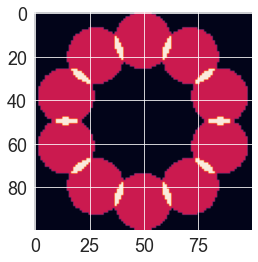

In [73]:
CircleOnCircumferenceDetector.plot((100, 100), 37, 13, 10)

In [9]:
path = '/content/drive/MyDrive/D2NN/trained_model/20220802_*'
files = glob.glob(path)
p = re.compile(r'\d+_\d+')
files.sort(reverse=False, key=lambda s: int(p.search(s).group()))
acc_list = []
for path in files:
  model = tf.keras.models.load_model(path)
  acc = model.evaluate(x_test, y_test)

  bi_model = tf.keras.models.load_model(path)
  pattern = r'mo'
  mo_layers = []
  save = False
  each_save = False
  for layer in bi_model.layers:
      result = re.match(pattern, layer.name)
      if result:
          mo_layers.append(layer)

  for layer in mo_layers:
      w = layer.get_weights()
      bi_w = np.where(w[0]>0, np.pi/2, -np.pi/2)
      w[0] = bi_w
      layer.set_weights(w)

  bi_acc = bi_model.evaluate(x_test, y_test)
  acc_list.append([acc[1], bi_acc[1]])

313/313 [==============================] - 2s 6ms/step - loss: 1.2677 - accuracy: 0.6334


In [14]:
df = pd.DataFrame(acc_list)
df.to_csv("acc.csv")

## 最適化

In [15]:
!pip install GPyOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 56 kB 3.6 MB/s 
     |████████████████████████████████| 959 kB 13.2 MB/s 
     |████████████████████████████████| 71 kB 10.4 MB/s 
  Created wheel for GPyOpt: filename=GPyOpt-1.2.6-py3-none-any.whl size=83609 sha256=08dc41a0daae960a08873a1fc3b5920f92fde5f6829c8358b61913b8297e11a5
  Stored in directory: /root/.cache/pip/wheels/e6/fa/d1/f9652b5af79f769a0ab74dbead7c7aea9a93c6bc74543fd3ec
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565116 sha256=6074b4fbaa7e1b25b6b4468eab041fdb4669e3fefbc033b88f1d4888b9c7da3c
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102566 sha256=f73eaaa23796fd89dbcf1bb984773b519234d82017dfcba4825ef78439a05740
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/c

In [25]:
import GPy
import GPyOpt

TensorFlow: 2.8.2
Python: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]


In [55]:
def create_model(**kwargs):
    z = kwargs["z"]
    r1 = kwargs["r1"]
    r2 = kwargs["r2"]
    wavelength = 532.0e-9
    d = 1.0e-6
    n = 1.5
    #tf.random.set_seed(kwargs["seed"])
    shape = (100, 100)
    inputs = tf.keras.Input((28, 28))
    theta = -2.79 * np.pi / 180
    eta = np.arctan(1.24 * np.pi/180)/2
    l1=1.0e-5
    print(kwargs)
    x = ImageResizing(shape)(inputs)
    x = ImageBinarization(0.5, 0.0, 1.0)(x)
    x = IntensityToElectricField(shape)(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.ShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=0.7e-3, d=d, n=1.51, method='expand')(x)
    x = MO(shape, limitation='sin', theta=theta, eta=eta, kernel_regularizer=regularizer.ShiftL1Regularizer(l1, np.pi/2))(x)
    x = AngularSpectrum(shape, wavelength=wavelength, z=z, d=d, n=1.00, method='expand')(x)
    # x = Polarizer(shape)(x)
    #x =ElectricFieldToIntensity(shape)(x)
    #x = MNISTFilter(shape)(x)
    x = FaradayRotationByStokes(shape)(x)
    # x = Argument(shape)(x)
    #x = MNISTDetector(10)(x)
    x = CircleOnCircumferenceDetector(10, r1, r2)(x)
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs, x)
    return model

In [54]:
history = []

In [56]:
count = 0
def train(**kwargs):
    global count
    count += 1
    model = create_model(**kwargs)
    model.summary()
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=tf.keras.losses.sparse_categorical_crossentropy,  # category: sparse_categorical_crossentropy
                  metrics=['accuracy'])

    epochs = 50
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy',
        min_delta=0.05,
        patience=2,
    )

    model_name = "20220802_BO/" + str(count)
    cholab_path = "/content/drive/MyDrive/D2NN/"
    checkpoint_path = cholab_path + "checkpoint/" + model_name + "/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    # チェックポイントコールバックを作る
    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                     save_weights_only=True,
                                                     verbose=1)

    logdir = os.path.join(cholab_path +"logs", model_name)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    result = model.fit(x_train,
                       y_train,
                       batch_size=64,
                       epochs=epochs,
                       validation_data=(x_val, y_val),
                       callbacks=[cp_callback, tensorboard_callback]
                       )

    path = cholab_path + "trained_model/"+ model_name
    model.save(path)

    df = pd.DataFrame(result.history)
    df.to_csv(path + "/history.csv")

    with open(path + "/config.json", 'w') as f:
        json.dump(model.get_config(), f, indent=4)

    bi_model = tf.keras.models.load_model(path)
    pattern = r'mo'
    mo_layers = []
    for layer in bi_model.layers:
        result = re.match(pattern, layer.name)
        if result:
            mo_layers.append(layer)

    for layer in mo_layers:
        w = layer.get_weights()
        bi_w = np.where(w[0]>0, np.pi/2, -np.pi/2)
        w[0] = bi_w
        layer.set_weights(w)
    evaluate = bi_model.evaluate(x_test, y_test)
    history.append([count, *kwargs, evaluate[0], evaluate[1]])
    df = pd.DataFrame(history)
    df.to_csv("/content/drive/MyDrive/D2NN/trained_model/20220802_BO/bo_history.csv")

    return evaluate

In [ ]:
bounds = [{'name': 'z',  'type': 'continuous',  'domain': (0.1e-3, 5.0e-3)},
          {'name': 'r1', 'type': 'discrete',  'domain': range(1,50)},
          {'name': 'r2', 'type': 'discrete',  'domain': range(1,50)}]

constraints = [
    {
        "name": "constr_1",
        "constraint": "(x[:,1] + x[:,2]) - 50" # r1 + r2 <= 50
    },
    {
        "name": "constr_2",
        "constraint": "x[:,1]*0.325 - x[:,2]" # r2 >= r1*tan(2pi/10)
    }
]

# ベイズ最適化する関数（上記で書いたブラックボックス）を定義します。
# xが入力で、出力はreturnされます。
def f(x):
    print(x)
    evaluation = train(
        z = float(x[:,0]),
        r1 = float(x[:,1]),
        r2 = int(x[:,2]))
    print("loss:{0} \t\t accuracy:{1}".format(evaluation[0], evaluation[1]))
    print(evaluation)
    return evaluation[0]

# 事前探索を行います。
opt_mnist = GPyOpt.methods.BayesianOptimization(f=f, domain=bounds, constraints=constraints)

# 最適なパラメータを探索します。
opt_mnist.run_optimization(max_iter=20)
print("optimized parameters: {0}".format(opt_mnist.x_opt))
print("optimized loss: {0}".format(opt_mnist.fx_opt))

[[0.00493996 3.         1.        ]]
{'z': 0.004939963658902567, 'r1': 3.0, 'r2': 1}
Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 28, 28)]          0         
                                                                 
 image_resizing_25 (ImageRes  (None, 100, 100)         0         
 izing)                                                          
                                                                 
 image_binarization_25 (Imag  (None, 100, 100)         0         
 eBinarization)                                                  
                                                                 
 intensity_to_electric_field  (None, 2, 100, 100)      0         
 _25 (IntensityToElectricFie                                     
 ld)                                                             
                                       